# Import

In [15]:
import numpy as np
import seaborn as sns
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

from xgboost import XGBClassifier
import torch
import os

RANDOM_STATE = 42

# Train/Test Split

In [16]:
fraud_train_df = pd.read_csv('../data/fraud_mock.csv')

In [17]:
X = fraud_train_df.drop(columns='is_fraud')
y = fraud_train_df['is_fraud']

In [18]:
split_point = int(fraud_train_df['time_ind'].max() * 0.7) 

train_df = fraud_train_df[fraud_train_df['time_ind'] <= split_point]
test_df = fraud_train_df[fraud_train_df['time_ind'] > split_point]

X_train = train_df.drop(columns='is_fraud')
y_train = train_df['is_fraud']
X_test = test_df.drop(columns='is_fraud')
y_test = test_df['is_fraud']

print(f"Data split: {len(X_train)} train, {len(X_test)} test rows.")

Data split: 6082007 train, 280613 test rows.


# Pipeline

## Custom createFeatures Class

In [19]:
from model_feature_engineer import AccountFeatureEngineer

## Overall Pipeline

In [20]:
num_cols = [
    'amount', 
    'src_bal', 
    'src_new_bal', 
    'dst_bal', 
    'dst_new_bal',
    'is_flagged_fraud',
    'hour_of_day',
    'Day'     
]
cat_cols = ['transac_type'] 

cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_pipe, cat_cols),
        ('num','passthrough',num_cols)],
    remainder='drop'
)

pipeline = Pipeline([
    ('feature_engineer', AccountFeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(n_estimators=200, 
                            random_state=RANDOM_STATE, 
                            learning_rate=0.1,
                            max_depth=6,
                            n_jobs=-1
                            ))
])

## Debug preprocessing

In [21]:
X_train_sample = X_test.head(100)
y_train_sample = y_train.head(100)

debug_pipeline = Pipeline([
    ('feature_engineer', AccountFeatureEngineer()),
    ('preprocessor', preprocessor)
])
debug_pipeline.fit(X_train_sample, y_train_sample)
processed_array = debug_pipeline.transform(X_train_sample.head(5))

cat_feature_names = debug_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['encoder'] \
    .get_feature_names_out(cat_cols).tolist()
num_feature_names = num_cols
all_feature_names = cat_feature_names + num_feature_names

processed_df = pd.DataFrame(
    processed_array, 
    columns=all_feature_names, 
    index=X_train_sample.head(5).index
)

print("\n--- Columns and Dtypes entering XGBoost ---")
print(processed_df.info())

print("\n--- List of Final Columns ---")
print(processed_df.columns.tolist())


--- Columns and Dtypes entering XGBoost ---
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 6082007 to 6082011
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transac_type_CASH_IN   5 non-null      float64
 1   transac_type_CASH_OUT  5 non-null      float64
 2   transac_type_DEBIT     5 non-null      float64
 3   transac_type_PAYMENT   5 non-null      float64
 4   transac_type_TRANSFER  5 non-null      float64
 5   amount                 5 non-null      float64
 6   src_bal                5 non-null      float64
 7   src_new_bal            5 non-null      float64
 8   dst_bal                5 non-null      float64
 9   dst_new_bal            5 non-null      float64
 10  is_flagged_fraud       5 non-null      float64
 11  hour_of_day            5 non-null      float64
 12  Day                    5 non-null      float64
dtypes: float64(13)
memory usage: 560.0 bytes
None

--- List of Fin

# Train & Evaluate

In [ ]:
# Fit Model 
model_dir = "../models"
model_path = os.path.join(model_dir, "fraud_model.joblib")

os.makedirs(model_dir, exist_ok=True)

pipeline.fit(X_train, y_train)
joblib.dump(pipeline, model_path)

['../model\\fraud_model.joblib']

Model Evaluation

1. Confusion Matrix:
[[278099     82]
 [   249   2183]]


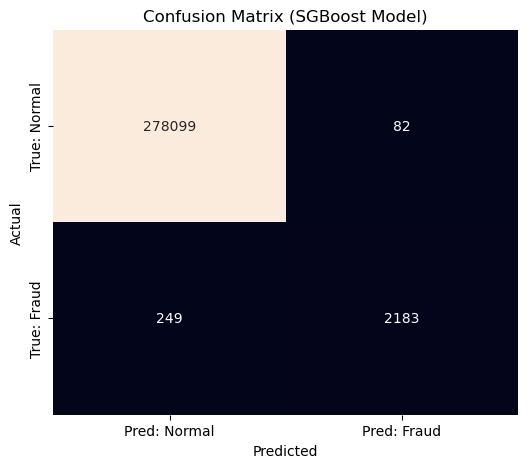


2. Classification Report:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00    278181
   Fraud (1)       0.96      0.90      0.93      2432

    accuracy                           1.00    280613
   macro avg       0.98      0.95      0.96    280613
weighted avg       1.00      1.00      1.00    280613


--- Summary ---
การโกงจริงใน Test Set มีทั้งหมด: 2432 รายการ
โมเดลของคุณสามารถ จับการโกงจริงได้: 2183 รายการ
โมเดลของคุณ พลาดการโกงจริงไป: 249 รายการ
โมเดลของคุณ กล่าวหาคนบริสุทธิ์ไป: 82 รายการ


In [23]:
print("Model Evaluation")

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n1. Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Fraud'],
            yticklabels=['True: Normal', 'True: Fraud'])
plt.title("Confusion Matrix (SGBoost Model)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)'])
print("\n2. Classification Report:")
print(report)

print("\n--- Summary ---")
tn, fp, fn, tp = cm.ravel()
print(f"การโกงจริงใน Test Set มีทั้งหมด: {tp+fn} รายการ")
print(f"โมเดลของคุณสามารถ จับการโกงจริงได้: {tp} รายการ")
print(f"โมเดลของคุณ พลาดการโกงจริงไป: {fn} รายการ")
print(f"โมเดลของคุณ กล่าวหาคนบริสุทธิ์ไป: {fp} รายการ")